In [314]:
import json
import re
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [347]:
train_df = pd.read_csv('./main_task.csv')
# train_df = pd.read_csv('./project-3/main_task.csv')

test_df = pd.read_csv('./kaggle_task.csv')
# test_df = pd.read_csv('./project-3/kaggle_task.csv')

In [348]:
train_df['Train'] = 1

test_df['Train'] = 0
test_df['Rating'] = 0

In [349]:
df = pd.concat([train_df, test_df]).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Rating             50000 non-null  float64
 5   Price Range        32639 non-null  object 
 6   Number of Reviews  46800 non-null  float64
 7   Reviews            49998 non-null  object 
 8   URL_TA             50000 non-null  object 
 9   ID_TA              50000 non-null  object 
 10  Train              50000 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [350]:
city_dummies = pd.get_dummies(df['City'], prefix='City')
df = pd.concat([df, city_dummies], axis=1)

In [351]:
df['No Cuisine Style Data'] = df['Cuisine Style'].isna().astype('float64')

In [352]:
import json

def parse_cuisine_style(cuisine_style):
    if pd.isna(cuisine_style):
        return np.nan

    data = json.loads(cuisine_style.replace("'", '"'))

    if len(data) == 0:
        return np.nan

    return [cs.lower() for cs in data]

df['Parsed Cuisine Style'] = df['Cuisine Style'].apply(parse_cuisine_style)

In [353]:
re_word = re.compile('[a-z]{4,16}', re.IGNORECASE)
re_date = re.compile('\d{2}/\d{2}/\d{4}')

def parse_review(value):
    if pd.isna(value):
        return np.nan

    dates = [datetime.strptime(d, '%m/%d/%Y') for d in re_date.findall(value)]
    words = [w.lower() for w in re_word.findall(value)]

    if len(words) == 0:
        return np.nan

    return {
        'dates': dates,
        'words': words,
    }

df['Parsed Reviews'] = df['Reviews'].apply(parse_review)
df['Parsed Reviews']

0        {'dates': [2017-12-31 00:00:00, 2017-11-20 00:...
1        {'dates': [2017-07-06 00:00:00, 2016-06-19 00:...
2        {'dates': [2018-01-08 00:00:00, 2018-01-06 00:...
3                                                      NaN
4        {'dates': [2017-11-18 00:00:00, 2017-02-19 00:...
                               ...                        
49995    {'dates': [2017-12-14 00:00:00, 2017-08-14 00:...
49996    {'dates': [2017-11-25 00:00:00], 'words': ['in...
49997                                                  NaN
49998                                                  NaN
49999    {'dates': [2016-07-30 00:00:00], 'words': ['et...
Name: Parsed Reviews, Length: 50000, dtype: object

In [354]:
cuisine_styles = set()
for cs_list in df['Parsed Cuisine Style']:
    if type(cs_list) != list and pd.isna(cs_list):
        continue

    for cs in cs_list:
        cuisine_styles.add(cs)

empty_cuisine_styles_map = df['Parsed Cuisine Style'].isna()
empty_cuisine_styles = df[empty_cuisine_styles_map]


found = 0
empty = 0
notfound = 0

for index, row in empty_cuisine_styles.iterrows():
    # reviews = row["Parsed Reviews"]
    reviews = row["Reviews"]
    
    if pd.isna(reviews):
        empty += 1
        df.at[index, 'Parsed Cuisine Style'] = ['other']
        continue

    # text = ' '.join(reviews['words'])
    text = reviews.lower()

    found_cuisin_styles = []

    for cs in cuisine_styles:
        if cs in text:
            found_cuisin_styles.append(cs)

    if len(found_cuisin_styles) > 0:
        found += 1
        df.at[index, 'Parsed Cuisine Style'] = found_cuisin_styles
    else:
        notfound += 1
        df.at[index, 'Parsed Cuisine Style'] = ['other']

print(f"Found: {found}, empty: {empty}, notfound: {notfound}") 
    

Found: 1688, empty: 2, notfound: 9900


In [355]:
df['Cuisine Styles Count'] = df['Parsed Cuisine Style'].apply(len).astype('float64')

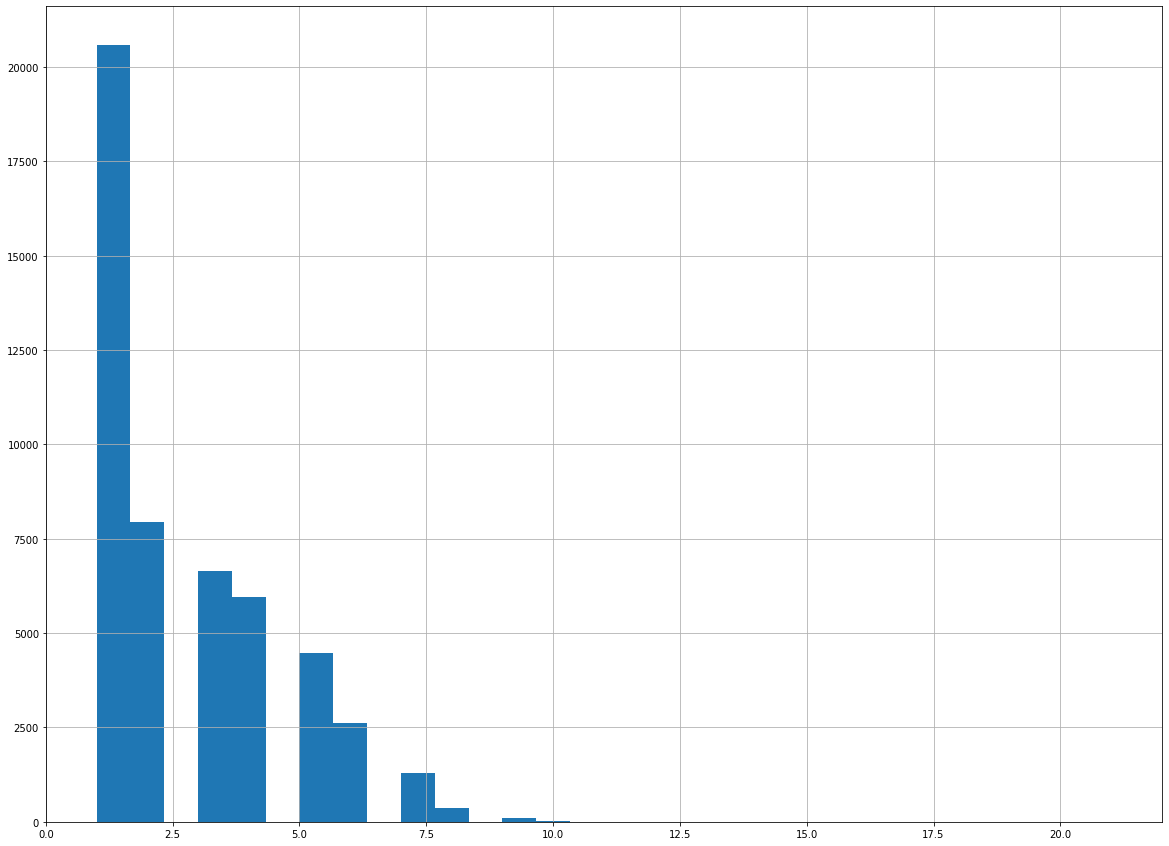

In [356]:
df['Cuisine Styles Count'].hist(bins=30)

In [357]:
df['Price Range'] = df['Price Range'].replace({'$': 1, '$$ - $$$': 2, '$$$$': 3})

In [358]:
df['Price Range'].fillna(df['Price Range'].median(), inplace=True)

In [359]:
dummy_price_ranges = pd.get_dummies(df['Price Range'], prefix="Price")
df = pd.concat([df, dummy_price_ranges], axis=1)

In [360]:
df['Number of Reviews'].fillna(df['Number of Reviews'].mean(), inplace=True)

In [361]:
def days_from_latest(reviews):
    if pd.isna(reviews):
        return np.nan

    if len(reviews['dates']) == 0:
        return np.nan

    date = sorted(reviews['dates'], reverse=True)[0]
    return (datetime.now() - date).days

df['Days From Latest Review'] = df['Parsed Reviews'].apply(days_from_latest)
df['Days From Latest Review'].fillna(df['Days From Latest Review'].median(), inplace=True)

In [362]:
def days_count(reviews):
    if pd.isna(reviews):
        return np.nan

    if len(reviews['dates']) < 2:
        return np.nan

    sorted_dates = sorted(reviews['dates'])
    first, last = sorted_dates[0], sorted_dates[-1]

    return (last - first).days

df['Days Between Reviews'] = df['Parsed Reviews'].apply(days_count)
df['Days Between Reviews'].fillna(df['Days Between Reviews'].median(), inplace=True)

In [366]:
mean_ranking_by_city = df.groupby(['City'])['Ranking'].mean()
max_ranking_by_city = df.groupby(['City'])['Ranking'].max()
std_ranking_by_city = df.groupby(['City'])['Ranking'].std()
count_resotrans_by_city = df.groupby(['City'])['Ranking'].count()

df['Restorans Count in City'] = df['City'].apply(lambda c: count_resotrans_by_city[c])

mean_ranking = df['City'].apply(lambda c: mean_ranking_by_city[c])
max_ranking = df['City'].apply(lambda c: max_ranking_by_city[c])
std_ranking = df['City'].apply(lambda c: std_ranking_by_city[c])

norm_ranking = (df['Ranking'] - mean_ranking) / std_ranking
norm_max_ranking = (df['Ranking'] - mean_ranking) / max_ranking

df['Norm Ranking'] = norm_ranking
df['Norm Max Ranking'] = norm_max_ranking

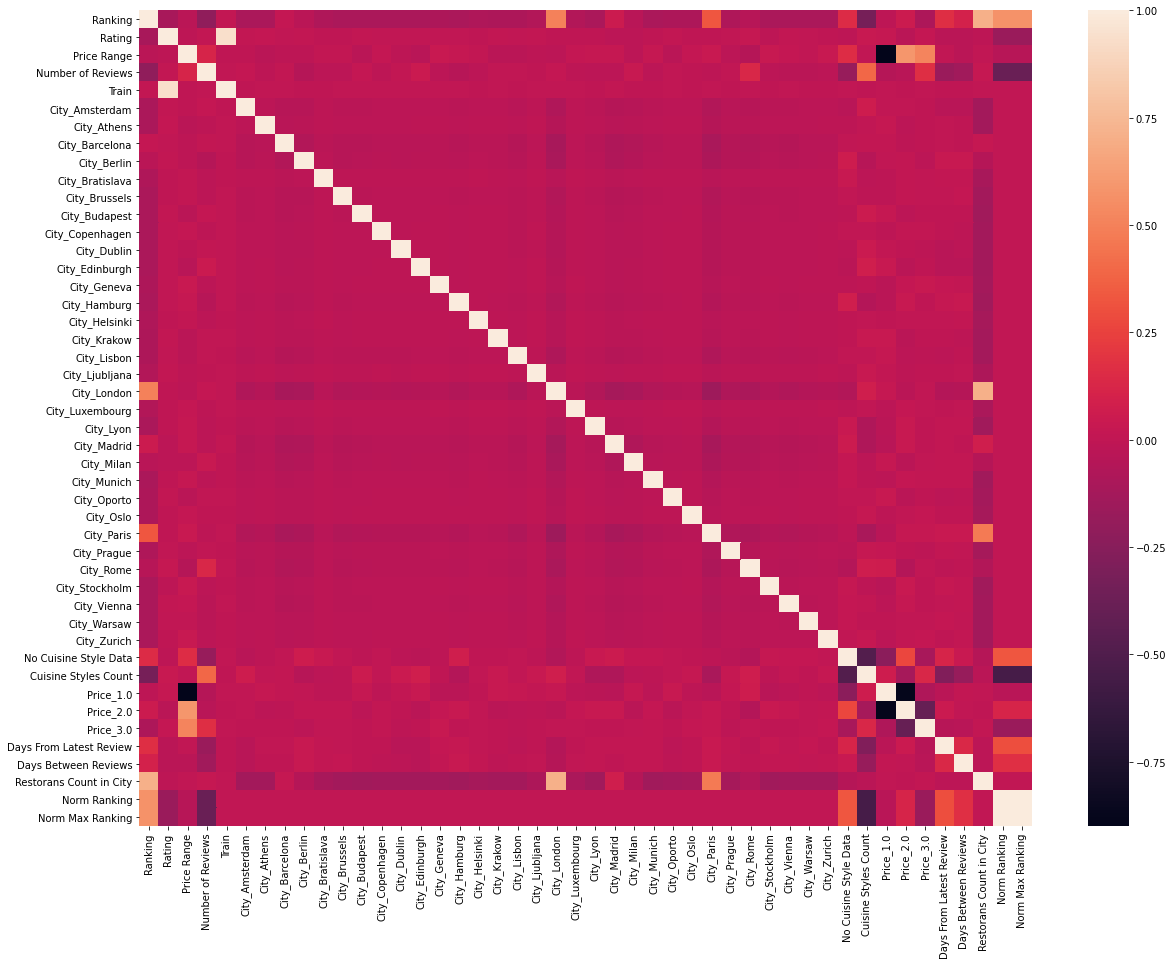

In [367]:
plt.rcParams['figure.figsize'] = (20,15)
sns.heatmap(df.corr())

In [368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  object 
 1   City                     50000 non-null  object 
 2   Cuisine Style            38410 non-null  object 
 3   Ranking                  50000 non-null  float64
 4   Rating                   50000 non-null  float64
 5   Price Range              50000 non-null  float64
 6   Number of Reviews        50000 non-null  float64
 7   Reviews                  49998 non-null  object 
 8   URL_TA                   50000 non-null  object 
 9   ID_TA                    50000 non-null  object 
 10  Train                    50000 non-null  int64  
 11  City_Amsterdam           50000 non-null  uint8  
 12  City_Athens              50000 non-null  uint8  
 13  City_Barcelona           50000 non-null  uint8  
 14  City_Berlin           

In [369]:
df.drop([
    'Restaurant_id', 
    'City', 
    'Cuisine Style', 
    'Parsed Cuisine Style',
    'Reviews', 
    'Parsed Reviews',
    'URL_TA', 
    'ID_TA',
    'Ranking',
], axis=1, inplace=True)

In [370]:
for col in df.columns:
    if col in ['Rating', 'Train', 'Norm Ranking', 'Norm Max Ranking']:
        continue

    transformed = StandardScaler().fit_transform(df[[col]])
    df[col] = transformed

In [371]:
df

,Rating,Price Range,Number of Reviews,Train,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,...,No Cuisine Style Data,Cuisine Styles Count,Price_1.0,Price_2.0,Price_3.0,Days From Latest Review,Days Between Reviews,Restorans Count in City,Norm Ranking,Norm Max Ranking
0,3.5,0.286525,0.244352,1,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,...,-0.549313,0.203798,-0.430446,0.487404,-0.192242,-0.626177,-0.419514,1.253945,-0.338757,-0.097852
1,4.0,0.286525,-0.402297,1,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,...,1.820457,-0.893897,-0.430446,0.487404,-0.192242,-0.095806,1.353149,-0.931892,0.414623,0.121558
2,4.5,2.660782,1.980463,1,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,...,-0.549313,2.399189,-0.430446,-2.051687,5.201765,-0.650013,-0.622253,1.721263,-1.654692,-0.475353
3,5.0,0.286525,-0.426898,1,-0.167971,-0.125557,-0.2699,4.181422,-0.087511,-0.164284,...,1.820457,-0.893897,-0.430446,0.487404,-0.192242,-0.340134,-0.284355,-0.211750,0.111518,0.031793
4,4.0,0.286525,-0.142232,1,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,...,-0.549313,0.203798,-0.430446,0.487404,-0.192242,-0.498053,0.781322,-0.883653,-0.930648,-0.271190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,-2.087731,-0.339038,0,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,...,-0.549313,0.752646,2.323173,-2.051687,-0.192242,-0.575523,0.001558,1.721263,-0.804982,-0.231252
49996,0.0,0.286525,-0.430412,0,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,...,-0.549313,0.752646,-0.430446,0.487404,-0.192242,-0.518911,-0.284355,-0.667438,0.695522,0.200342
49997,0.0,0.286525,-0.430412,0,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,...,1.820457,-0.893897,-0.430446,0.487404,-0.192242,-0.340134,-0.284355,-0.216488,1.364884,0.391390
49998,0.0,0.286525,-0.430412,0,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,...,-0.549313,-0.893897,-0.430446,0.487404,-0.192242,-0.340134,-0.284355,-0.216488,0.502374,0.144059


In [372]:
def train(df, target="Rating"):
    X = df.drop([target, ], axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    regr = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    regr.fit(X_train, y_train)

    y_pred = regr.predict(X_test)

    mea = metrics.mean_absolute_error(y_pred, y_test)

    return regr, mea

In [374]:
train_df = df.query('Train == 1').drop(['Train'], axis=1)
regr, mea = train(train_df)
print(mea)

0.207373


In [375]:
test_df = df.query('Train == 0').drop(['Train', 'Rating'], axis=1)
y_pred = regr.predict(test_df)

In [376]:
@np.vectorize
def post_process(rating):
    return min(5, max(0, np.round(rating, 2)))

In [377]:
y_pred = post_process(y_pred)

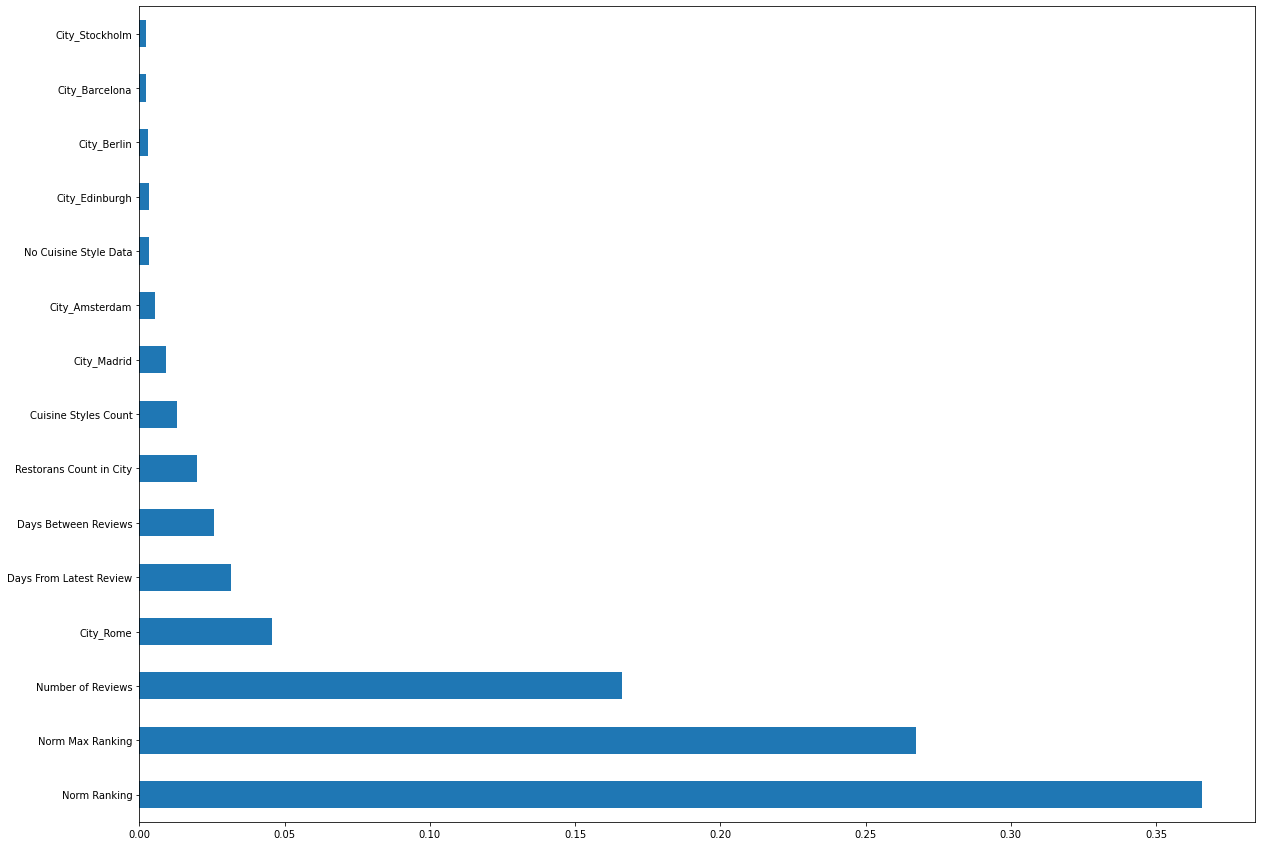

In [378]:
imp = pd.Series(regr.feature_importances_, index=test_df.columns)
imp.nlargest(15).plot(kind='barh')

In [380]:
sample_df = pd.read_csv('submission.csv')
sample_df['Rating'] = y_pred
sample_df.to_csv('submission.csv', index=False)